In [10]:
%matplotlib inline

Comparison of training a hardware efficient ansatz with a global cost function and the gadget equivalent

Necessary imports

In [11]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import datetime

from gadget_utils import hardware_efficient_ansatz, cat_state_preparation

np.random.seed(42)

Defining the relevant parameters of the simulation

In [12]:
computational_qubits = 4
ancillary_qubits = 4
num_layers = 2
max_iter = 500
# num_samples = 200
perturbation_factor = 0.5
locality = computational_qubits
lambda_max = (locality - 1) / (4 * locality)
gate_set = [qml.RX, qml.RY, qml.RZ]

Global cost function
--------

creating the quantum device with the right number of qubits

In [13]:
dev_comp = qml.device("default.qubit", wires=range(computational_qubits))

creating the qunode using the imported methods

In [14]:
def computational_circuit(angles, gate_sequence, measured_qubits):
    assert(len(np.shape(angles)) == 2)                  # check proper dimensions of params
    total_qubits = np.shape(angles)[1]
    if total_qubits > measured_qubits:
        # /!\ keep the 'ancillary_qubits = ' (has to be a keyword argument)
        cat_state_preparation(ancillary_qubits = range(measured_qubits, total_qubits, 1))
    hardware_efficient_ansatz(angles, gate_sequence=gate_sequence)
    H = qml.PauliZ(0)
    for qubit in range(measured_qubits-1):
        H = H @ qml.PauliZ(qubit + 1)
    return qml.expval(H)

computational_qnode = qml.QNode(computational_circuit, dev_comp)

(defining the cost function)

In [15]:
def computational_cost_function(angles, gate_sequence, computational_qubits):
    return computational_qnode(angles, gate_sequence, computational_qubits)

Choosing an optimizer

In [16]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

Initializing the parameters

In [17]:
weights_init = np.random.uniform(0, np.pi, size=(num_layers, computational_qubits), requires_grad=True)
random_gate_sequence = [[np.random.choice(gate_set) for _ in range(computational_qubits)] for _ in range(num_layers)]
cost_computational = [computational_cost_function(weights_init, random_gate_sequence, computational_qubits)]

Optimization loop

In [18]:
weights = weights_init
for it in range(max_iter):
    # /!\ keyword arguments are not trained? don't know why but don't remove the 'computational_qubits='
    # keyword arguments are not wrapped https://discuss.pennylane.ai/t/wire-error-on-ibm-simulator/1282
    weights = opt.step(computational_cost_function, weights, gate_sequence=random_gate_sequence, computational_qubits=computational_qubits)
    cost_computational.append(computational_cost_function(weights, random_gate_sequence, computational_qubits))
    # opt.update_stepsize(stepsize)
    if it % 50 == 0:
        print("Iteration = {:5d} | Cost function = {: .8f}".format(it+1, cost_computational[-1]))


Iteration =     1 | Cost function =  0.38768563
Iteration =    51 | Cost function = -0.58594696
Iteration =   101 | Cost function = -0.99054813
Iteration =   151 | Cost function = -0.99883764
Iteration =   201 | Cost function = -0.99985651
Iteration =   251 | Cost function = -0.99998229
Iteration =   301 | Cost function = -0.99999781
Iteration =   351 | Cost function = -0.99999973
Iteration =   401 | Cost function = -0.99999997
Iteration =   451 | Cost function = -1.00000000


Saving and plotting the results

In [19]:
with open('../../results/data/{}_training_global_{}qubits_{}layers_{}iterations.dat'
            .format(datetime.datetime.now().strftime("%y%m%d"),
                    computational_qubits, num_layers, max_iter), 'w') as of:
    of.write('# iteration\tcost\n')

    for it in range(max_iter+1):
        of.write('{}\t{}\n'.format(it, cost_computational[it]))

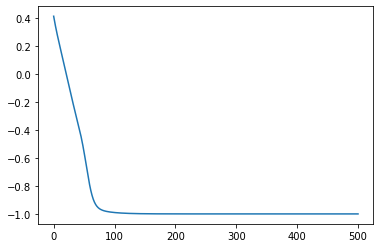

In [20]:
plt.plot(np.arange(max_iter+1), cost_computational)
plt.show()

Local cost function
--------

In [29]:
def local_circuit(angles, gate_sequence):
    assert(len(np.shape(angles)) == 2)                  # check proper dimensions of params
    hardware_efficient_ansatz(angles, gate_sequence)
    H = qml.PauliZ(0) @ qml.PauliZ(1)
    return qml.expval(H)

local_qnode = qml.QNode(local_circuit, dev_comp)

In [30]:
def local_cost_function(angles, gate_sequence):
    return local_qnode(angles, gate_sequence)

In [31]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

In [32]:
weights_init = np.random.uniform(0, np.pi, size=(num_layers, computational_qubits), requires_grad=True)
random_gate_sequence = [[np.random.choice(gate_set) for _ in range(computational_qubits)] for _ in range(num_layers)]
cost_local = [local_cost_function(weights_init, random_gate_sequence)]

In [33]:
weights = weights_init
for it in range(max_iter):
    weights = opt.step(local_cost_function, weights, gate_sequence=random_gate_sequence)
    cost_local.append(local_cost_function(weights, random_gate_sequence))
    if it % 50 == 0:
        print("Iteration = {:5d} | Cost function = {: .8f}".format(it+1, cost_local[-1]))


Iteration =     1 | Cost function = -0.43750924
Iteration =    51 | Cost function = -0.99932510
Iteration =   101 | Cost function = -0.99971227
Iteration =   151 | Cost function = -0.99985993
Iteration =   201 | Cost function = -0.99993056
Iteration =   251 | Cost function = -0.99996526
Iteration =   301 | Cost function = -0.99998254
Iteration =   351 | Cost function = -0.99999121
Iteration =   401 | Cost function = -0.99999557
Iteration =   451 | Cost function = -0.99999776


In [34]:
with open('../../results/data/{}_training_local_{}qubits_{}layers_{}iterations.dat'
            .format(datetime.datetime.now().strftime("%y%m%d"),
                    computational_qubits, num_layers, max_iter), 'w') as of:
    of.write('# iteration\tcost\n')

    for it in range(max_iter+1):
        of.write('{}\t{}\n'.format(it, cost_local[it]))

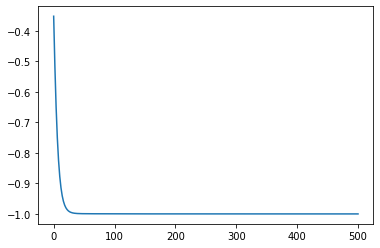

In [35]:
plt.plot(np.arange(max_iter+1), cost_local)
plt.show()

Gadget cost function
--------

In [36]:
dev_gad = qml.device("default.qubit", wires=range(computational_qubits+ancillary_qubits))

In [37]:
def gadget_circuit(params, gate_sequence, computational_qubits):       # also working for k'-local 
    assert(len(np.shape(params)) == 2)                  # check proper dimensions of params
    total_qubits = np.shape(params)[1]
    cat_state_preparation(ancillary_qubits = range(computational_qubits, total_qubits, 1))
    hardware_efficient_ansatz(params, gate_sequence)

In [38]:
@qml.qnode(dev_gad)
def unperturbed_qnode(params, gate_sequence, computational_qubits, target_qubits):
    gadget_circuit(params, gate_sequence, computational_qubits)
    term = qml.Identity(target_qubits[0]) @ qml.Identity(target_qubits[1]) - qml.PauliZ(target_qubits[0]) @ qml.PauliZ(target_qubits[1])
    return qml.expval(term)


@qml.qnode(dev_gad)
def perturbation_qnode(params, gate_sequence, computational_qubits, target_qubits):
    gadget_circuit(params, gate_sequence, computational_qubits)
    term = qml.PauliZ(target_qubits[0]) @ qml.PauliX(computational_qubits+target_qubits[0])
    return qml.expval(term)


def gadget_cost_function(params, gate_sequence, computational_qubits):
    assert(len(np.shape(params)) == 2)                  # check proper dimensions of params
    total_qubits = np.shape(params)[1]
    expectation_value = 0
    # creating the "unperturbed Hamiltonian"
    # acting on the ancillary qubits only
    for first_qubit in range(computational_qubits, total_qubits):
        for second_qubit in range(first_qubit+1, total_qubits):
            expectation_value += unperturbed_qnode(params, gate_sequence, computational_qubits, [first_qubit, second_qubit])
    # creating the perturbation part of the Hamiltonian
    # acting on both ancillary and target qubits with the same index
    for qubit in range(computational_qubits):           # /!\ only valid for 2-local
        expectation_value += perturbation_factor * lambda_max * perturbation_qnode(params, gate_sequence, computational_qubits, [qubit])
    return expectation_value

In [39]:
control_qnode = qml.QNode(computational_circuit, dev_gad)
def control_cost_function(params, gate_sequence, computational_qubits):
    return control_qnode(params, gate_sequence, computational_qubits)

In [40]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)

In [42]:
weights_init = np.random.uniform(0, np.pi, size=(num_layers, computational_qubits+ancillary_qubits), requires_grad=True)
random_gate_sequence = [[np.random.choice(gate_set) for _ in range(computational_qubits+ancillary_qubits)] for _ in range(num_layers)]
cost_computational = [control_cost_function(weights_init, gate_sequence=random_gate_sequence, computational_qubits=computational_qubits)]
cost_gadget = [gadget_cost_function(weights_init, random_gate_sequence, computational_qubits)]


In [43]:
weights = weights_init
for it in range(max_iter):
    weights, prev_cost = opt.step_and_cost(gadget_cost_function, weights, gate_sequence=random_gate_sequence, computational_qubits=computational_qubits)
    cost_computational.append(control_cost_function(weights, random_gate_sequence, computational_qubits))
    cost_gadget.append(gadget_cost_function(weights, random_gate_sequence, computational_qubits))
    # opt.update_stepsize(stepsize)
    if it % 10 == 0:
        print(f"Iteration = {it:5d} | " +
               "Gadget cost = {:.8f} | ".format(cost_gadget[-1]) +
               "Computational cost = {:.8f}".format(cost_computational[-1]))


Iteration =     0 | Gadget cost = 6.23889793 | Computational cost = -0.11358374
Iteration =    10 | Gadget cost = 2.39641822 | Computational cost = -0.11664320
Iteration =    20 | Gadget cost = 1.75274496 | Computational cost = -0.11315067
Iteration =    30 | Gadget cost = 1.75127985 | Computational cost = -0.10849027
Iteration =    40 | Gadget cost = 1.75058665 | Computational cost = -0.10374309
Iteration =    50 | Gadget cost = 1.74992792 | Computational cost = -0.09893235
Iteration =    60 | Gadget cost = 1.74930704 | Computational cost = -0.09410030
Iteration =    70 | Gadget cost = 1.74872649 | Computational cost = -0.08928645
Iteration =    80 | Gadget cost = 1.74818778 | Computational cost = -0.08452670
Iteration =    90 | Gadget cost = 1.74769150 | Computational cost = -0.07985277
Iteration =   100 | Gadget cost = 1.74723738 | Computational cost = -0.07529187
Iteration =   110 | Gadget cost = 1.74682445 | Computational cost = -0.07086658
Iteration =   120 | Gadget cost = 1.7464

In [44]:
with open('../../results/data/{}_training_gadget_{}qubits_{}layers_{}iterations_{}lambda.dat'
            .format(datetime.datetime.now().strftime("%y%m%d"),
                    computational_qubits, num_layers, max_iter, perturbation_factor), 'w') as of:
    of.write('# iteration\tcost\n')

    for it in range(max_iter+1):
        of.write('{}\t{}\n'.format(it, cost_computational[it]))

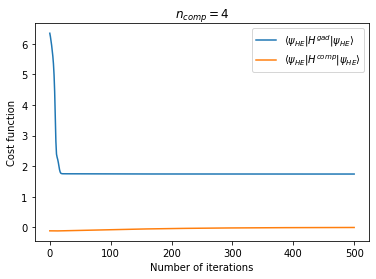

In [45]:
fig, ax = plt.subplots()
ax.plot(np.arange(max_iter+1), cost_gadget, label=r'$\langle \psi_{HE}| H^{gad} |\psi_{HE} \rangle$')
ax.plot(np.arange(max_iter+1), cost_computational, label=r'$\langle \psi_{HE}| H^{comp} |\psi_{HE} \rangle$')
ax.set_xlabel(r"Number of iterations")
ax.set_ylabel(r"Cost function")
ax.legend()
ax.set_title(r"$n_{comp}=$"+"{}".format(computational_qubits))
plt.show()